In [47]:

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import shapiro, levene, mannwhitneyu
from scipy.stats import ttest_ind, norm, chi2_contingency

pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

import warnings
warnings.filterwarnings("ignore")


## En este archivo se realizara el A/B Testing solicitado en la fase 3

In [48]:
# Objetivo del Ejercicio: Utilizando un conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos
# reservados según el nivel educativo de los clientes. Para ello, los pasos que deberas seguir son:
    # 1. Preparación de Datos:
    # Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.
    # 2. Análisis Descriptivo:
    # Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estandar, los percentiles) del número de vuelos reservados para cada grupo.
    # 3. Prueba Estadística:
    # Realiza una prueba de A/B testing para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos

In [49]:
df_final = pd.read_csv("files/df_final.csv", index_col = 0)

In [50]:
df_final.head()

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year_month,enrollment_year_month,cancellation_year_month
0,100018,2017,1,3,0,3,1521,152.000,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.000,Married,Aurora,7919.200,Standard,2016,8,Unknown,Unknown,2017/1,2016/8,Unknown/Unknown
1,100102,2017,1,10,4,14,2030,203.000,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,NaN,Single,Nova,2887.740,Standard,2013,3,Unknown,Unknown,2017/1,2013/3,Unknown/Unknown
2,100140,2017,1,6,0,6,1200,120.000,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,NaN,Divorced,Nova,2838.070,Standard,2016,7,Unknown,Unknown,2017/1,2016/7,Unknown/Unknown
3,100214,2017,1,0,0,0,0,0.000,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.000,Married,Star,4170.570,Standard,2015,8,Unknown,Unknown,2017/1,2015/8,Unknown/Unknown
4,100272,2017,1,0,0,0,0,0.000,0,0,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.000,Divorced,Star,6622.050,Standard,2014,1,Unknown,Unknown,2017/1,2014/1,Unknown/Unknown


In [51]:
df_filtrado = df_final[["loyalty_number", "flights_booked", "education"]]

In [52]:
df_filtrado.head()

,loyalty_number,flights_booked,education
0,100018,3,Bachelor
1,100102,10,College
2,100140,6,College
3,100214,0,Bachelor
4,100272,0,Bachelor


In [53]:
df_filtrado["education"].value_counts()

education
Bachelor                252567
College                 102260
High School or Below     18915
Doctor                   17731
Master                   12287
Name: count, dtype: int64

In [54]:
df_filtrado["education_level"] = df_filtrado["education"].apply(lambda dato: "Nivel alto" if dato in ["Doctor", "Master", "Bachelor"] else "Nivel bajo")
df_filtrado.head()

,loyalty_number,flights_booked,education,education_level
0,100018,3,Bachelor,Nivel alto
1,100102,10,College,Nivel bajo
2,100140,6,College,Nivel bajo
3,100214,0,Bachelor,Nivel alto
4,100272,0,Bachelor,Nivel alto


In [55]:
for col in df_filtrado["education_level"].unique():
    print(f"Educacion de {col}")
    print(df_filtrado[df_filtrado["education_level"] ==  col]["flights_booked"].describe())
    print("\n--------------------------------\n")

Educacion de Nivel alto
count   282585.000
mean         4.118
std          5.224
min          0.000
25%          0.000
50%          1.000
75%          8.000
max         21.000
Name: flights_booked, dtype: float64

--------------------------------

Educacion de Nivel bajo
count   121175.000
mean         4.171
std          5.245
min          0.000
25%          0.000
50%          1.000
75%          8.000
max         21.000
Name: flights_booked, dtype: float64

--------------------------------



In [56]:
#Las metricas son muy parecidas en ambos grupos excepto el conteo que nos muestra que hay muchos mas clientes con un nivel alto de educacion

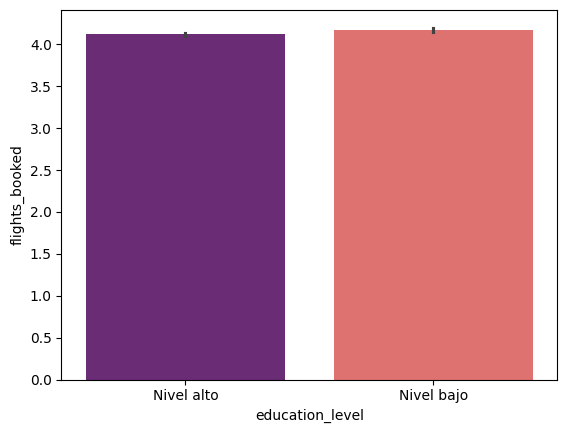

In [57]:
sns.barplot(x = "education_level", y = "flights_booked", data = df_filtrado, palette = "magma");
#aqui vemos las medias en un barplot

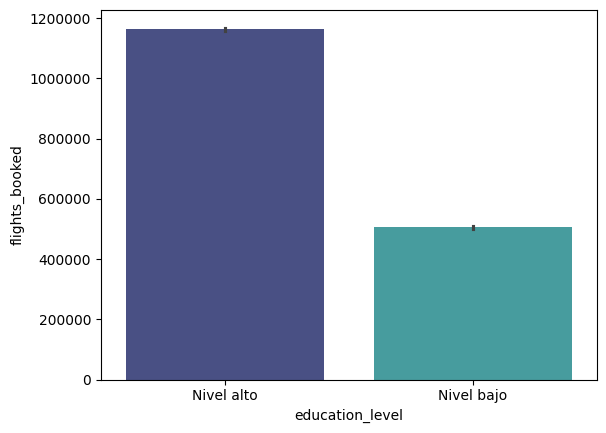

In [58]:
df = df_filtrado[["education_level", "flights_booked"]]
sns.barplot(x = "education_level", 
            y = "flights_booked",
              data = df, 
              palette = "mako", estimator = sum)

plt.ticklabel_format(style='plain', axis='y')
#usamos tambien un barplot para mostrar la suma del numero de vuelos reservados por cliente

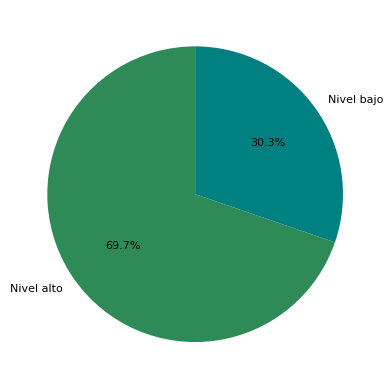

In [59]:
df_estudios = df_filtrado.groupby("education_level")["flights_booked"].sum().reset_index()
colores = ["seagreen", "teal", "green"]

# creamos el gráfico basándonos en el DataFrame que hemos creado en el paso anterior
plt.pie("flights_booked", labels= "education_level",
        data = df_estudios, 
        autopct=  '%1.1f%%', 
        colors = colores, 
        textprops={'fontsize': 8}, 
        startangle=90);

In [60]:
#Para realizar la prueba de A/B testing:

#Establecemos las hipotesis:
#   H0: No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos
#   H1: Si existe una diferencia significativa

#si p_value < 0.05 -> rechazamos H0
#si p_value > 0.05 -> mantenemos H0

In [61]:
#1. Prueba de normalidad
#Establecemos las hipotesis:
#   H0: Los datos siguen una distribucion normal
#   H1: Los datos no siguen una distribucion normal

#si p_value < 0.05 -> rechazamos H0
#si p_value > 0.05 -> mantenemos H0

_,p_value = shapiro(df_filtrado["flights_booked"])
print(f"p-Value: {p_value}")

p-Value: 1.5469185716221557e-164


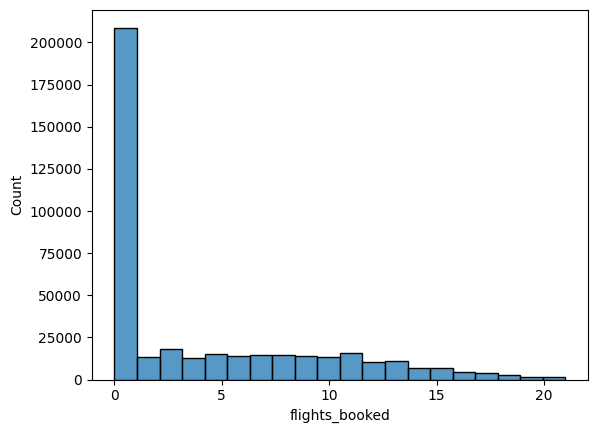

In [68]:
sns.histplot(data=df_filtrado, x="flights_booked", bins = 20);

In [62]:
# Ademas de comprobar visualmente que los datos no parecen seguir una distribucion normal, el p_value es menor que 0.05 por lo que rechazamos H0, tenemos evidencia suficiente para afirmar que los datos no siguen una distribucion normal.

In [63]:
#Realizamos la prueba de Mann Whitney, ya que no se cumple el criterio de normalidad (en este caso no es necesario comprobar la homogeneidad de varianza ni la independencia)
#Establecemos las hipotesis:
#   H0: Los datos no son significativamente diferentes
#   H1: Los datos son significativamente diferentes

#si p_value < 0.05 -> rechazamos H0
#si p_value > 0.05 -> mantenemos H0

In [64]:
nivel_alto = df_filtrado[df_filtrado["education_level"] == "Nivel alto"]
nivel_bajo = df_filtrado[df_filtrado["education_level"] == "Nivel bajo"]

In [65]:
u_statistic, p_value = stats.mannwhitneyu(nivel_alto['flights_booked'], nivel_bajo['flights_booked'])
        
if p_value < 0.05:
    print(f"Las medianas son significativamente diferentes.")
else:
    print(f"Las medianas no son significativamente diferentes.")

Las medianas son significativamente diferentes.


### Conclusion

Tras todas las pruebas y visualizaciones podemos concluir que sí existe una diferencia significativa entre el numero de vuelos reservados segun el nivel educativo.

Los clientes con niveles de educacion mas altos (suponiendo que estos son "Doctor", "Master", "Bachelor") reservan muchos mas vuelos que los que tienen un nivel mas bajo